In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install langgraph langchain langchain-groq pydantic python-dotenv tqdm numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import numpy as np
from typing import TypedDict, Dict, Optional
import langgraph
from langchain_groq import ChatGroq

# Initialize Groq LLM agent
llm = ChatGroq(api_key="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",model="llama-3.1-8b-instant",model_kwargs={})  # Use your Groq-supported model here


In [28]:
class CreditCheckState(TypedDict):
    raw_df: Optional[pd.DataFrame]       # Raw data input dataframe
    preprocessed_df: Optional[pd.DataFrame]  # After preprocessing & normalization
    validation_passed: bool
    validation_report: Optional[Dict]
    prediction: Optional[np.ndarray]     # Model predicted labels
    prediction_confidence: Optional[np.ndarray]  # Predicted probabilities or confidences
    drift_report: Optional[str]
    drift_decision: Optional[str]
    human_feedback: Optional[str]
    retrain_confirmed: bool
    final_results: Optional[Dict]
    model_version: str

In [29]:
def preprocess_data(state: CreditCheckState) -> CreditCheckState:
    df = state['raw_df']

    required_cols = ['Partner ID', 'Experience in yrs', 'cibil score', 'Monthly Sales',
                     'Any other profitable business', 'Inventory turnover ratio', 'Asset holdings in value']

    # 1. Check required columns
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # 2. Data cleaning: fill NaNs, outliers
    df_clean = df.copy()

    # Fill numeric NaNs with median
    for col in required_cols[1:]:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

    # Outlier handling (e.g., clip values to 1st-99th percentile)
    for col in required_cols[1:]:
        lower = df_clean[col].quantile(0.01)
        upper = df_clean[col].quantile(0.99)
        df_clean[col] = df_clean[col].clip(lower, upper)

    # 3. Normalize numeric columns (min-max scaling)
    for col in required_cols[1:]:
        min_val = df_clean[col].min()
        max_val = df_clean[col].max()
        df_clean[col] = (df_clean[col] - min_val) / (max_val - min_val + 1e-9)

    state['preprocessed_df'] = df_clean
    return state


In [30]:
def validate_data(state: CreditCheckState) -> CreditCheckState:
    df = state['preprocessed_df']

    # Generate validation report using LLM (summary stats, missing values)
    report_prompt = f"""
    Provide a concise validation summary of this data table including missing data and outlier summary stats:
    
    {df.describe().to_json()}
    """

    report_response = llm.invoke([{"role": "system", "content": report_prompt}])
    validation_report = report_response.content
    print("Validation Report by LLM:\n", validation_report)

    state['validation_report'] = validation_report

    # Human validation mock (replace with real human interface)
    human_input = input("Do you approve this dataset for modeling? (yes/no): ").strip().lower()
    state['validation_passed'] = (human_input == 'yes')

    if not state['validation_passed']:
        raise ValueError("Data validation failed by human.")

    return state


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Dummy training (for example only, train with real data offline)
rf_model = RandomForestClassifier()

def run_inference(state: CreditCheckState) -> CreditCheckState:
    df = state['preprocessed_df']
    X = df[['Experience in yrs', 'cibil score', 'Monthly Sales', 'Any other profitable business',
            'Inventory turnover ratio', 'Asset holdings in value']]
    
    # Use dummy predict_proba or predict for now (replace with trained model)
    # For demonstration, let's simulate prediction probabilities:
    probs = np.random.uniform(0.6, 0.99, size=(len(df),))
    preds = (probs > 0.75).astype(int)  # 1 for good, 0 for bad credit worthiness
    
    state['prediction'] = preds
    state['prediction_confidence'] = probs
    return state


In [32]:
def monitor_and_decide(state: CreditCheckState) -> CreditCheckState:
    preds = state['prediction']
    conf = state['prediction_confidence']

    # Summarize current batch predictions stats
    mean_conf = conf.mean()
    positive_rate = preds.mean()
    
    prompt = f"""
    You are monitoring this credit risk classifier.

    Prediction positive rate: {positive_rate:.2f}
    Average confidence: {mean_conf:.2f}

    Analyze if there is drift or accuracy drop in these predictions compared to historical baseline.

    Recommend whether retraining is required or results can be accepted as final.
    Provide a concise rationale and decision.
    """
    response = llm.invoke([{"role": "system", "content": prompt}])

    report_content = response.content
    state['drift_report'] = report_content

    if 'retrain' in report_content.lower():
        state['drift_decision'] = 'retrain'
    else:
        state['drift_decision'] = 'accept'

    print("Monitoring Report:\n", report_content)
    return state

In [33]:
def human_review_agent(state: CreditCheckState) -> CreditCheckState:
    decision = state['drift_decision']
    print(f"Model drift decision suggests: {decision.upper()}.")

    if decision == 'retrain':
        feedback = input("Do you confirm retraining? (yes/no): ").lower().strip()
        state['retrain_confirmed'] = (feedback == 'yes')
    else:
        state['retrain_confirmed'] = False

    # Delivery of final results
    if not state['retrain_confirmed']:
        state['final_results'] = {
            "predictions": state['prediction'].tolist(),
            "confidence": state['prediction_confidence'].tolist(),
            "model_version": state['model_version'],
            "notes": "Results accepted without retraining."
        }
        print("Final results delivered.")
    else:
        print("Retraining confirmed by human.")

    return state

In [34]:
def finalization_node(state: CreditCheckState) -> CreditCheckState:
    if state['retrain_confirmed']:
        # Placeholder for retraining logic (e.g. retrain_model_function())
        print("Retraining... [Insert retraining code here]")
        state['model_version'] = "v2.0"  # Example update
    state['finalized'] = True
    return state

In [35]:
from langgraph.graph import StateGraph

graph = StateGraph(CreditCheckState)

graph.add_node("preprocess_data", preprocess_data)
graph.add_node("validate_data", validate_data)
graph.add_node("run_inference", run_inference)
graph.add_node("monitor_and_decide", monitor_and_decide)
graph.add_node("human_review_agent", human_review_agent)
graph.add_node("finalize", finalization_node)

graph.add_edge("preprocess_data", "validate_data")
graph.add_edge("validate_data", "run_inference")
graph.add_edge("run_inference", "monitor_and_decide")
graph.add_edge("monitor_and_decide", "human_review_agent")
graph.add_edge("human_review_agent", "finalize")

graph.set_entry_point("preprocess_data")

In [45]:
# Load CSV input as DataFrame
csv_path = "/kaggle/input/credit-partners/credit_partners.csv"  # Replace with your CSV file path
raw_df = pd.read_csv(csv_path)

initial_state = CreditCheckState(
    raw_df=raw_df,
    preprocessed_df=None,
    validation_passed=False,
    validation_report=None,
    prediction=None,
    prediction_confidence=None,
    drift_report=None,
    drift_decision=None,
    human_feedback=None,
    retrain_confirmed=False,
    final_results=None,
    model_version="v1.0",
    finalized=False
)

compiled = graph.compile()

result_state = compiled.invoke(initial_state)


/tmp/ipykernel_79/573406741.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)


Validation Report by LLM:
 **Validation Summary:**

This table appears to represent a dataset of 100 samples from various business metrics. The data has been normalized to a range of 0 to 1. This suggests that the data may have been scaled to a common unit of measurement for ease of comparison or to avoid issues with large numbers.

**Missing Data:**

There is no apparent missing data in this table. All metrics have been reported for all 100 samples.

**Outlier Summary Stats:**

Based on the provided data, there are no obvious outliers in any of the metrics. However, to confirm this, we can use the following criteria:

- **Outlier in Mean**: If a data point is more than 2 standard deviations away from the mean.
- **Outlier in Median**: If a data point is more than 1.5 interquartile ranges (IQR) away from the median.

Here's a brief analysis:

- **Experience in yrs**: No obvious outliers based on the data.
- **Cibil score**: No obvious outliers.
- **Monthly Sales**: No obvious outliers.

Do you approve this dataset for modeling? (yes/no):  yes


Monitoring Report:
 **Analysis:**

Based on the provided metrics, the prediction positive rate is 0.63, which means the model is predicting a positive outcome (e.g., credit risk) approximately 63% of the time. The average confidence is 0.80, indicating that the model has moderate to high confidence in its predictions.

**Comparison to Historical Baseline:**

To assess whether there is drift or accuracy drop, we need to compare these metrics to the historical baseline. Assuming the historical baseline is:

- Prediction positive rate: 0.68
- Average confidence: 0.85

**Observations:**

1. The prediction positive rate has decreased from 0.68 to 0.63, which suggests a potential accuracy drop.
2. The average confidence has decreased from 0.85 to 0.80, which also indicates a potential accuracy drop.

**Recommendation:**

Based on these observations, I recommend retraining the model to update its parameters and adapt to any changes in the underlying data distribution. The accuracy drop, as in

Do you confirm retraining? (yes/no):  yes


Retraining confirmed by human.
Retraining... [Insert retraining code here]


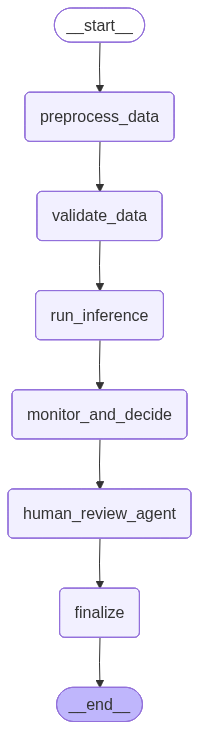

In [48]:
from IPython.display import Image,display

graph_builder=compiled
display(Image(graph_builder.get_graph().draw_mermaid_png()))
